# Feature Preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
primary_key = ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time']

## Load The Raw Features

### Text

In [3]:
text_train = pd.read_csv('../features/raw_train_text_features.csv', index_col=0)
text_test = pd.read_csv('../features/raw_test_text_features.csv', index_col=0)

### Speech

In [4]:
speech_train = pd.read_csv('../features/raw_train_speech_features.csv', index_col=0)
speech_test = pd.read_csv('../features/raw_test_speech_features.csv', index_col=0)

## Create Text + Speech Features

In [5]:
text_speech_train = pd.merge(text_train, speech_train, on=primary_key)
text_speech_test = pd.merge(text_test, speech_test, on=primary_key)

## Filter "NaN"

First, visualize which features are taking NaN values.

In [6]:
na_counts = {}

for col in speech_train:
    if not col in primary_key:
        na_counts[col] = speech_train[col].isna().sum()

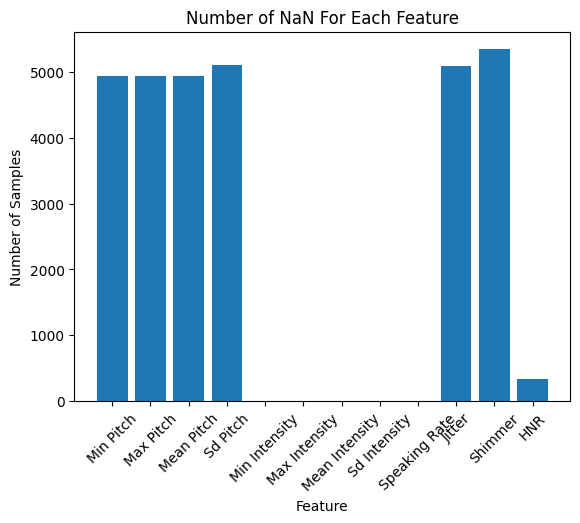

In [7]:
plt.bar(na_counts.keys(), na_counts.values())

plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Number of Samples')
plt.title('Number of NaN For Each Feature')

plt.show()

See if there is a correlation with the length of the sound.

In [8]:
durations = []
num_nas = []

for row, item in speech_train.iterrows():
    num_na = item.isna().sum()
    if (num_na):
        durations.append(item['end_time'] - item['start_time'])
        num_nas.append(num_na)

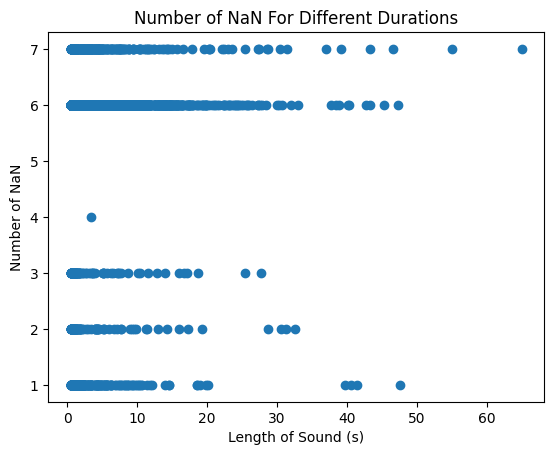

In [9]:
plt.scatter(durations, num_nas)

plt.xlabel('Length of Sound (s)')
plt.ylabel('Number of NaN')
plt.title('Number of NaN For Different Durations')

plt.show()

Next, see if there is a correlation with the dialogue act (normalized).

In [10]:
da_counts = {}

for row, item in speech_train.groupby('da_tag'):
    da_counts[row] = item.isna().sum().sum() / len(item)

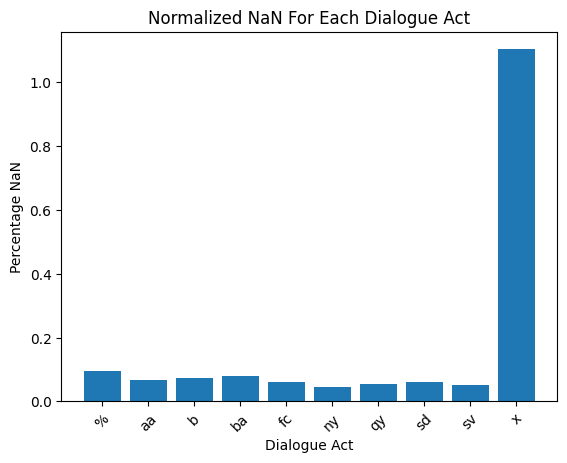

In [11]:
plt.bar(da_counts.keys(), da_counts.values())

plt.xticks(rotation=45)
plt.xlabel('Dialogue Act')
plt.ylabel('Percentage NaN')
plt.title('Normalized NaN For Each Dialogue Act')

plt.show()

Most `NaN` values occur with the silence (x) dialogue act.

How many samples contain a `NaN` value?

In [12]:
na_rows = 0
total_rows = 0

for row, item in speech_train.iterrows():
    total_rows += 1
    if (item.isna().sum() > 0):
        na_rows += 1
        
print("{:.2f}% rows contain a NaN value".format(na_rows / total_rows))

0.09% rows contain a NaN value


Since so few rows contain a `NaN` value, we will simply omit these rows.

In [13]:
speech_train = speech_train.dropna(axis=0)
speech_test = speech_test.dropna(axis=0)

In [14]:
text_speech_train = text_speech_train.dropna(axis=0)
text_speech_test = text_speech_test.dropna(axis=0)

## Distribute Classes

As shown below, the classes are very unbalanced. We downsample the larger classes and upsample the smaller classes.

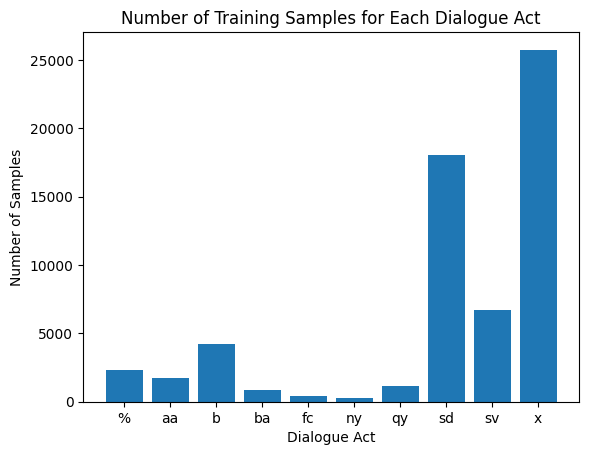

In [15]:
da_tags = []
num_samples = []

for row, item in text_train.groupby('da_tag'):
    da_tags.append(row)
    num_samples.append(len(item))

plt.bar(da_tags, num_samples)

plt.xlabel('Dialogue Act')
plt.ylabel('Number of Samples')
plt.title('Number of Training Samples for Each Dialogue Act')

plt.show()

In [16]:
def resample_df(df, n):
    sampled_dfs = []

    for row, item in df.groupby('da_tag'):
        sampled_dfs.append(item.sample(n=n, replace=True, random_state=1))

    return pd.concat(sampled_dfs)    

In [17]:
text_train = resample_df(text_train, 15000)
speech_train = resample_df(speech_train, 15000)
text_speech_train = resample_df(text_speech_train, 15000)

## Normalize

`min-max` feature scaling

Reference: https://www.geeksforgeeks.org/data-normalization-with-pandas/

In [19]:
def min_max_scale(df):
    for column in df.columns:
        if (not column in primary_key):
            df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

In [20]:
min_max_scale(text_train)
min_max_scale(text_test)

In [21]:
min_max_scale(speech_train)
min_max_scale(speech_test)

In [22]:
min_max_scale(text_speech_train)
min_max_scale(text_speech_test)

## Write to CSV File

In [23]:
text_train.to_csv('../features/train_text_features.csv')
text_test.to_csv('../features/test_text_features.csv')

In [24]:
speech_train.to_csv('../features/train_speech_features.csv')
speech_test.to_csv('../features/test_speech_features.csv')

In [25]:
text_speech_train.to_csv('../features/train_features.csv')
text_speech_test.to_csv('../features/test_features.csv')